# import

In [1]:
# MLP tools #
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dense, Input, MaxPooling2D, MaxPool2D, 
                                     Conv2D, Flatten, Dropout, Conv1D, LSTM, 
                                     SimpleRNN, GRU, MaxPool1D, GlobalMaxPool1D, 
                                     Embedding, BatchNormalization) 
from tensorflow.keras.activations import sigmoid, softmax, relu
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# viz
from tensorboard.plugins.hparams import api as hp 
%load_ext tensorboard
import pydot 
import graphviz 
# ML tools #
import sklearn 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
# nlp tools
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# data handling tools #
import numpy as np
import pandas as pd 
# plotting tools #
import matplotlib.pyplot as plt 
import seaborn as sns 
# general tools #
import datetime
from collections import Counter
import os 
pjoin = os.path.join
import gc
import pickle 
import itertools
import re 
import string 

# load

In [2]:
times = pd.DataFrame(columns=['time'])
history = pd.DataFrame(columns=['accuracy', 'val_accuracy'])
param = pd.DataFrame(columns=['conv_layers', 'filters', 'kernel_size', 
                              'pool_size', 'dense_hidden_layers', 
                              'optimizer', 'lr', 'do_rate', 'batch_normalize', 
                              'batch_size'])
test_acc = pd.DataFrame(columns=['test_acc'])

for fname in os.listdir('./results/bm_lists'):
    if not fname.startswith('.'):
        idx = fname.split('_')[0].zfill(3)
        loaded_ls = pickle.load(open(pjoin('./results/bm_lists', fname), 'rb'))        
        if 'time' in fname:
            times.loc[idx] = loaded_ls[-1]
        elif 'history' in fname:
            ser = pd.DataFrame(loaded_ls[-1])[['accuracy', 'val_accuracy']].max()
            history.loc[idx] = ser 
        elif 'param' in fname:
            df = pd.DataFrame(loaded_ls[-1], index=[idx])
            param = param.append(df)
        elif 'test' in fname:
            test_acc.loc[idx] = loaded_ls[-1]
        else:
            print('ugh oh...', fname)


# concat frames
res = pd.concat([history, test_acc, param, times], axis=1)
res.rename({'accuracy':'train_acc', 'val_accuracy':'val_acc'}, axis=1, inplace=True)
res.index.name = 'model'
res.sort_values('val_acc', ascending=False, inplace=True)
# res.to_excel('gridsearch_tb_results.xlsx', columns=res.columns)
# pickle.dump(res, open('gridsearch_tb_res.pkl', 'wb'))
res.head(10) 

,train_acc,val_acc,test_acc,conv_layers,filters,kernel_size,pool_size,dense_hidden_layers,optimizer,lr,do_rate,batch_normalize,batch_size,time
model,,,,,,,,,,,,,,
243,0.952500,0.863281,0.675127,4,64,7,2,0,adam,0.001,0.4,False,64,"minutes:13, seconds:57"
264,0.967500,0.863281,0.560914,4,128,3,2,1,adam,0.001,0.0,True,64,"minutes:13, seconds:55"
281,0.931667,0.855469,0.652284,4,128,7,2,1,adam,0.001,0.0,False,64,"minutes:16, seconds:11"
265,0.940833,0.851562,0.634518,4,128,3,2,1,adam,0.001,0.0,False,64,"minutes:12, seconds:23"
267,0.950833,0.851562,0.626904,4,128,3,2,1,adam,0.001,0.4,False,64,"minutes:14, seconds:28"
257,0.945000,0.847656,0.598985,4,128,3,2,0,adam,0.001,0.0,False,64,"minutes:14, seconds:44"
248,0.952500,0.847656,0.586294,4,64,7,2,1,adam,0.001,0.0,True,64,"minutes:12, seconds:28"
152,0.985833,0.847656,0.715736,3,64,7,2,1,adam,0.001,0.0,True,64,"minutes:12, seconds:38"
142,0.979167,0.847656,0.649746,3,64,3,2,1,adam,0.010,0.4,True,64,"minutes:11, seconds:20"


In [3]:
res.sort_values('test_acc', ascending=False).head(10)

,train_acc,val_acc,test_acc,conv_layers,filters,kernel_size,pool_size,dense_hidden_layers,optimizer,lr,do_rate,batch_normalize,batch_size,time
model,,,,,,,,,,,,,,
152,0.985833,0.847656,0.715736,3,64,7,2,1,adam,0.001,0.0,True,64,"minutes:12, seconds:38"
108,0.944167,0.820312,0.692893,3,32,3,2,1,adam,0.010,0.0,True,64,"minutes:10, seconds:19"
137,0.959167,0.839844,0.680203,3,64,3,2,1,adam,0.001,0.0,False,64,"minutes:14, seconds:21"
131,0.926809,0.792969,0.677665,3,64,3,2,0,adam,0.001,0.4,False,64,"minutes:11, seconds:42"
243,0.952500,0.863281,0.675127,4,64,7,2,0,adam,0.001,0.4,False,64,"minutes:13, seconds:57"
145,0.948333,0.804688,0.664975,3,64,7,2,0,adam,0.001,0.0,False,64,"minutes:10, seconds:45"
161,0.945833,0.792969,0.662437,3,128,3,2,0,adam,0.001,0.0,False,64,"minutes:09, seconds:25"
171,0.890000,0.773438,0.659898,3,128,3,2,1,adam,0.001,0.4,False,64,"minutes:07, seconds:52"
281,0.931667,0.855469,0.652284,4,128,7,2,1,adam,0.001,0.0,False,64,"minutes:16, seconds:11"


In [5]:
res.loc['top3',:]

KeyError: 'top3'

# correlations 

In [39]:
numeric = res.drop(['optimizer', 'batch_normalize', 'time', 
                    'batch_size', 'pool_size', 'val_acc', 'train_acc'], 
                   axis=1).copy().astype(float)
categorical = res[['batch_normalize']].copy() 
categorical = pd.get_dummies(categorical, drop_first=True)
corr_ready = pd.concat([numeric, categorical], axis=1)
corr_mat = corr_ready.corr('pearson')

Text(0.5, 1.0, "Correlations (Pearson's r)")

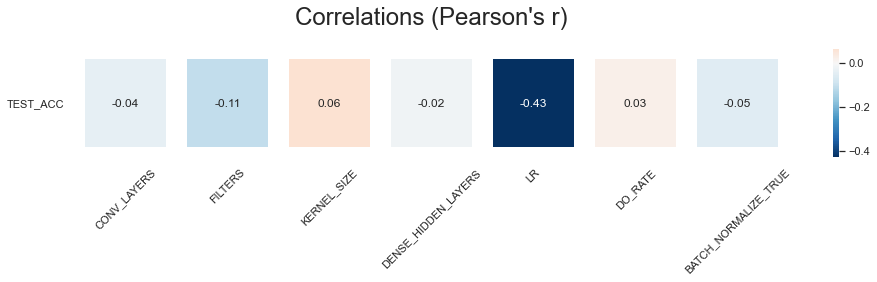

In [40]:
corr_mat.index = corr_mat.index.str.upper() 
corr_mat.columns = corr_mat.columns.str.upper() 
sns.set(style='white', palette='RdBu_r')
sns.heatmap(corr_mat.iloc[0:1,1:], annot=True, fmt='.02f', linewidths=20, cmap='RdBu_r', center=0)
plt.gcf().set_size_inches((16,2))
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Correlations (Pearson\'s r)', fontsize=24, pad=24)
# plt.savefig('./images/correlations.png', dpi=600, bbox_inches='tight')

# top 5

In [41]:
top5 = res.sort_values('test_acc', ascending=False).iloc[:5]
top5 

,train_acc,val_acc,test_acc,conv_layers,filters,kernel_size,pool_size,dense_hidden_layers,optimizer,lr,do_rate,batch_normalize,batch_size,time
model,,,,,,,,,,,,,,
152,0.985833,0.847656,0.715736,3,64,7,2,1,adam,0.001,0.0,True,64,"minutes:12, seconds:38"
108,0.944167,0.820312,0.692893,3,32,3,2,1,adam,0.010,0.0,True,64,"minutes:10, seconds:19"
137,0.959167,0.839844,0.680203,3,64,3,2,1,adam,0.001,0.0,False,64,"minutes:14, seconds:21"
131,0.926809,0.792969,0.677665,3,64,3,2,0,adam,0.001,0.4,False,64,"minutes:11, seconds:42"
243,0.952500,0.863281,0.675127,4,64,7,2,0,adam,0.001,0.4,False,64,"minutes:13, seconds:57"


In [49]:
top5.median().round(3) 

train_acc               0.952
val_acc                 0.840
test_acc                0.680
conv_layers             3.000
filters                64.000
kernel_size             3.000
pool_size               2.000
dense_hidden_layers     1.000
lr                      0.001
do_rate                 0.000
batch_normalize         0.000
batch_size             64.000
dtype: float64

In [43]:
top5.optimizer.describe()

count        5
unique       1
top       adam
freq         5
Name: optimizer, dtype: object

# visualize

### train and test accuracies

In [44]:
top5_long = top5.reset_index().melt(id_vars='model', 
                                value_vars=['train_acc', 'test_acc'], 
                                var_name='metric', value_name='accuracy')
top5_long.head() 

,model,metric,accuracy
0,152,train_acc,0.985833
1,108,train_acc,0.944167
2,137,train_acc,0.959167
3,131,train_acc,0.926809
4,243,train_acc,0.952500


Text(29.056279166666677, 0.5, 'Accuracy')

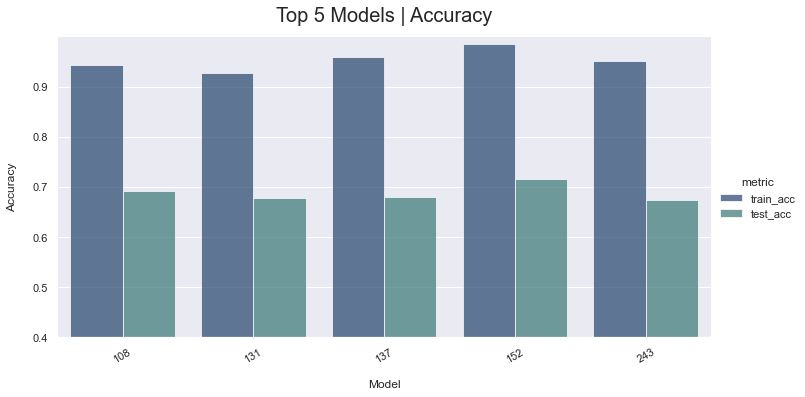

In [45]:
sns.set(style='darkgrid', palette='gist_earth')
g = sns.catplot(x='model', y='accuracy', hue='metric', 
                data=top5_long, kind='bar', alpha=.7, aspect=2)
plt.xticks(rotation=30)
plt.yticks(np.arange(.4, 1., .1))
plt.ylim(.4, 1.)
plt.title('Top 5 Models | Accuracy', fontsize=20, pad=15)
plt.xlabel('Model', labelpad=15)
plt.ylabel('Accuracy', labelpad=15)

# plt.savefig('./images/top5_train_val.png', dpi=600, bbox_inches='tight')

In [46]:
df = top5.reset_index() 
df.model = df.model.astype(str)
df

,model,train_acc,val_acc,test_acc,conv_layers,filters,kernel_size,pool_size,dense_hidden_layers,optimizer,lr,do_rate,batch_normalize,batch_size,time
0,152,0.985833,0.847656,0.715736,3,64,7,2,1,adam,0.001,0.0,True,64,"minutes:12, seconds:38"
1,108,0.944167,0.820312,0.692893,3,32,3,2,1,adam,0.010,0.0,True,64,"minutes:10, seconds:19"
2,137,0.959167,0.839844,0.680203,3,64,3,2,1,adam,0.001,0.0,False,64,"minutes:14, seconds:21"
3,131,0.926809,0.792969,0.677665,3,64,3,2,0,adam,0.001,0.4,False,64,"minutes:11, seconds:42"
4,243,0.952500,0.863281,0.675127,4,64,7,2,0,adam,0.001,0.4,False,64,"minutes:13, seconds:57"


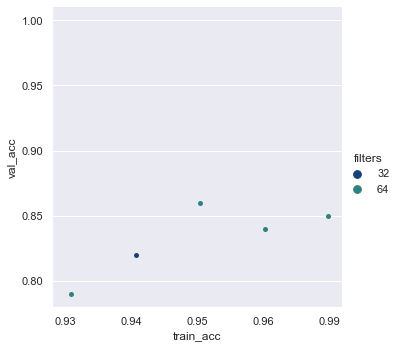

In [47]:
sns.set(style='darkgrid', palette='gist_earth')
g = sns.catplot(x='train_acc', y='val_acc', hue='filters', kind='strip', data=df.round(2))
g.ax.plot([0,0], [1,1], 'b--', )


# plt.xticks(np.arange(.927, .96, .005))
# plt.yticks(np.arange(.927, .94, .005))
# plt.title('Top 5 Models | Accuracy Balance', fontsize=15, pad=15)
# plt.xlabel('Training Accuracy', labelpad=10)
# plt.ylabel('Validation Accuracy', labelpad=10)

# plt.legend(loc=(1.01, .1))

# plt.savefig('./images/top5_balance.png', dpi=600, bbox_inches='tight')

# export

In [48]:
top3_dict = top5.iloc[:3].drop(['train_acc', 'val_acc', 'test_acc', 'time'], axis=1).to_dict('index') 
pickle.dump(top3_dict, open('top3_dict.pkl', 'wb'))
top3_dict

{'152': {'conv_layers': 3,
  'filters': 64,
  'kernel_size': 7,
  'pool_size': 2,
  'dense_hidden_layers': 1,
  'optimizer': 'adam',
  'lr': 0.001,
  'do_rate': 0.0,
  'batch_normalize': True,
  'batch_size': 64},
 '108': {'conv_layers': 3,
  'filters': 32,
  'kernel_size': 3,
  'pool_size': 2,
  'dense_hidden_layers': 1,
  'optimizer': 'adam',
  'lr': 0.01,
  'do_rate': 0.0,
  'batch_normalize': True,
  'batch_size': 64},
 '137': {'conv_layers': 3,
  'filters': 64,
  'kernel_size': 3,
  'pool_size': 2,
  'dense_hidden_layers': 1,
  'optimizer': 'adam',
  'lr': 0.001,
  'do_rate': 0.0,
  'batch_normalize': False,
  'batch_size': 64}}